In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [2]:
og = pd.read_csv('/Users/gracesaunders/Downloads/World Development Indicators Jan 28 2025 (1)/WDICSV.csv')
og.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,17.488497,18.001597,18.558234,19.043572,19.586457,20.192064,20.828814,21.372164,22.100884,NaN
1,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,6.811504,7.096003,7.406706,7.666648,8.020952,8.403358,8.718306,9.097176,9.473374,NaN
2,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,38.152090,38.488233,38.779953,39.068462,39.445526,39.818645,40.276374,40.687817,41.211606,NaN
3,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,31.871956,33.922276,38.859598,40.223744,43.035073,44.390861,46.282371,48.127211,48.742043,NaN
4,Africa Eastern and Southern,AFE,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,17.672943,16.527554,24.627753,25.432092,27.061929,29.154282,31.022083,32.809138,33.760782,NaN


In [3]:
# remove other ODA data
exclude_keywords = r"(?i)\baid\b|development assistance|ODA|primary income|official flows"
non_oda_data = og[~og['Indicator Name'].str.contains(exclude_keywords, na=False)]

target_oda_data = og[og['Indicator Code'] == "DT.ODA.ODAT.KD"]

df_filtered = pd.concat([non_oda_data, target_oda_data])

In [4]:
df = df_filtered.loc[:,['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']]

In [5]:
df = df[df.index >= 72281]

In [6]:
df_long = df.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="Year",
    value_name="Value"
)

df_pivot = df_long.pivot_table(
    index=["Country Name", "Country Code", "Year"],
    columns="Indicator Name",
    values="Value"
).reset_index()

In [7]:
df_pivot = df_pivot[df_pivot['Net official development assistance received (constant 2021 US$)'].notna()]

In [13]:
df_pivot = df_pivot.sort_values(["Country Code", "Year"])
df_pivot.to_csv('pivot_data.csv')

In [ ]:
# Load data
df = df_pivot.copy()

df['target_lag1'] = df.groupby('Country Code')['Net official development assistance received (constant 2021 US$)'].shift(1)
df = df.dropna(subset=['target_lag1'])
df['Year'] = df['Year'].astype(int)

# separate features from target 
y = np.arcsinh(df['target_lag1']) # transform because of skew
X = df.drop(columns=['Net official development assistance received (constant 2021 US$)', 'Country Name', 'Country Code', 'Year'])

# handle missing values with mask
missing_mask = X.isnull()
X = X.fillna(0)
for col in X.columns[missing_mask.any()]:
    X[f'{col}_missing'] = missing_mask[col].astype(int)

# Time-based split (using original year column)
valid_indices = df['target_lag1'].notna()
cutoff = 2016
train_mask = (df['Year'] <= cutoff) & valid_indices
test_mask = (df['Year'] > cutoff) & valid_indices

X_train, X_test = X.loc[train_mask], X.loc[test_mask]
y_train, y_test = y.loc[train_mask], y.loc[test_mask]

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/var/folders/rs/40ldjcbs0ks2l9sptdb8835c0000gn/T/ipykernel_25508/3397562256.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{col}_missing'] = missing_mask[col].astype(int)
/var/folders/rs/40ldjcbs0ks2l9sptdb8835c0000gn/T/ipykernel_25508/3397562256.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f'{col}_missing'] = missing_mask[col].astype(int)
/var/folders/rs/40ldjcbs0ks2l9sptdb8835c0000gn/T/ipykernel_25508/3397562256.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

Train RMSE: 2.3248
Test RMSE: 53.2917
Train R^2: 0.7830
Test R^2: -76.7297


/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.013e+03, tolerance: 2.112e+00
  model = cd_fast.enet_coordinate_descent(


In [ ]:

lasso = Lasso(
    alpha = 0.0999,
    max_iter=100000,
    warm_start=True,
    random_state=42,
    selection='random')
lasso.fit(X_train_scaled, y_train)

train_pred = lasso.predict(X_train_scaled)
test_pred = lasso.predict(X_test_scaled)

print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, train_pred)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.4f}")

print(f"Train R^2: {lasso.score(X_train_scaled, y_train):.4f}")
print(f"Test R^2: {lasso.score(X_test_scaled, y_test):.4f}")

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Try a range of alpha values
alphas = np.logspace(-4, 2, 50)
r2_train = []
r2_test = []

for alpha in alphas:
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(X_train_scaled, y_train)
    r2_train.append(model.score(X_train_scaled, y_train))
    r2_test.append(model.score(X_test_scaled, y_test))

results = pd.concat([pd.Series(alphas, name='Alpha'), pd.Series(r2_train, name='Train R²'), pd.Series(r2_test, name='Test R²')], axis=1)
results.sort_values(by='Test R²', ascending=False, inplace=True)
print("Best Alpha:", results.iloc[0])

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(alphas, r2_train, label='Train R²')
plt.plot(alphas, r2_test, label='Test R²')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('R² Score')
plt.title('Lasso Regression Performance')
plt.legend()
plt.grid(True)
plt.show()


/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.717e+01, tolerance: 2.112e+00
  model = cd_fast.enet_coordinate_descent(
/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.085e+01, tolerance: 2.112e+00
  model = cd_fast.enet_coordinate_descent(
/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective 

KeyboardInterrupt: 

In [170]:
# Get top 20 features
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso.coef_,
    'Absolute_Impact': np.abs(lasso.coef_)
}).sort_values('Absolute_Impact', ascending=False)

top_20 = feature_importance.head(20)
print(top_20)

                                                Feature  Coefficient  \
2326   Personal remittances, paid (current US$)_missing    -4.185686   
2723  Women who believe a husband is justified in be...     3.751788   
1843       Firms that spend on R&D (% of firms)_missing    -3.024784   
1500  Average time to clear exports through customs ...     2.974410   
2688  Unmet need for contraception (% of married wom...    -2.936055   
2438                Rail lines (total route-km)_missing    -2.731767   
2229  Net financial flows, others (NFL, current US$)...     2.643620   
920   People using safely managed drinking water ser...     2.589856   
2050  Internally displaced persons, total displaced ...    -2.574193   
1457  Adolescents out of school (% of lower secondar...     2.535416   
1505  Average working hours of children, study and w...    -2.510212   
1789  Exclusive breastfeeding (% of children under 6...    -2.388814   
1504  Average working hours of children, study and w...    -2.36

Computing regularization path...


/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.945e+04, tolerance: 3.488e+01
  model = cd_fast.enet_coordinate_descent(
/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e+04, tolerance: 3.488e+01
  model = cd_fast.enet_coordinate_descent(
/Users/gracesaunders/Documents/GitHub/DS3001Project/DS3001Project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective 

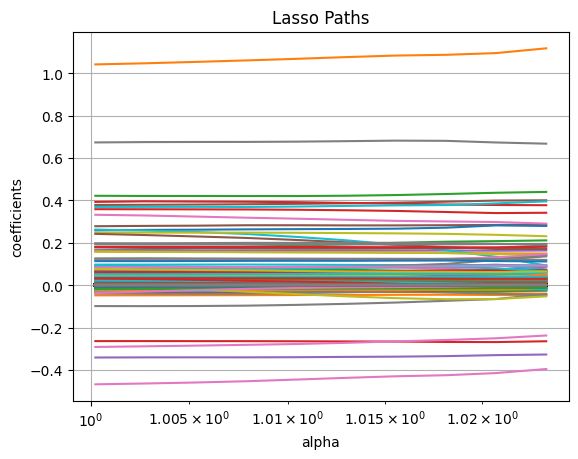

In [178]:
from sklearn.linear_model import lasso_path
from matplotlib import pyplot as plt

eps = 5e-10

print("Computing regularization path...")
alphas_lasso, coefs_lasso, _ = lasso_path(X_train_scaled, y_train, eps=eps, alphas=(np.logspace(.01, .0001, 10)))

for coef in coefs_lasso:
    l1 = plt.semilogx(alphas_lasso, coef)

plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("Lasso Paths")
plt.axis("tight")
plt.grid()